# Agriculture Crop Yield: Predict Fertilizer Use

> *By: Jaeyoung Oh*
> 
> *GitHub: https://github.com/BlueJayVRStudio/CSCA5632_final*

## Introduction:

For my Unsupervised Learning final project, I have chosen to investigate patterns of fertilizer use in crops using a large agriculture crop yield dataset from Kaggle. The dataset, with over a million data points and various features such as region, soil type, and rainfall, presents plethora of information to be mined. While predicting crop yield would be a natural approach, I found that it would be interesting to predict fertilizer use in particular crops. For instance, modeling fertilizer use could be beneficial when making quick decisions as to whether fertilizer should be used in particular farms, taking into account their unique characteristics. Such decisions could yield positive financial outcomes, while increasing opportunities for automation in logistics. In this notebook, I will explore various unsupervised methods, as well as supervised learning methods, to discover latent patterns in fertilizer use and optimize predictive accuracy of selected models.

### References:
##### dataset: https://www.kaggle.com/datasets/samuelotiattakorah/agriculture-crop-yield

The author of the dataset also posted a preliminary EDA. We will use this as a reference and adjust it to the needs of this project

##### EDA reference: https://www.kaggle.com/code/samuelotiattakorah/eda-on-agriculture-crop-yield

## Initial Project Setup

In [214]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from helpers.metrics import *

import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import accuracy_score, confusion_matrix

In [215]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# please, no warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=ConvergenceWarning)
os.environ['PYTHONWARNINGS']='ignore'

## Iterative Data Cleaning and EDA

In [216]:
num_tests = 5
tests_passed = 0

In [217]:
# import data
df_crop_yield = pd.read_csv('./data/crop_yield.csv')

### Data Description

In [218]:
df_crop_yield.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Region                  1000000 non-null  object 
 1   Soil_Type               1000000 non-null  object 
 2   Crop                    1000000 non-null  object 
 3   Rainfall_mm             1000000 non-null  float64
 4   Temperature_Celsius     1000000 non-null  float64
 5   Fertilizer_Used         1000000 non-null  bool   
 6   Irrigation_Used         1000000 non-null  bool   
 7   Weather_Condition       1000000 non-null  object 
 8   Days_to_Harvest         1000000 non-null  int64  
 9   Yield_tons_per_hectare  1000000 non-null  float64
dtypes: bool(2), float64(3), int64(1), object(4)
memory usage: 62.9+ MB


There are **no null values**, so conveniently we do not have to fill in any missing values. However, we still have numerous preprocessing steps to ensure that our data is ready for clustering tasks.
> - Separate "Fertilizer_Used" from rest of the data frame since we'll be using that as target class,
> - "Region", "Soil_Type" and "Crop" are non-ordinal categorical data, thus we need to convert them to binary, one-hot encoding,
> - "Weather_Condition" is also categorical, but one could argue that it is ordinal since cloud cover is directly proportional to sunlight and precipitation. Using just one of those two relationships should suffice,
> - For the rest of the numerical columns, we will perform quick outlier analysis and drop them as we have sufficient data. We will also ensure that no column has over-influence by using standard scaling,
> - Random sample portion of the dataset, since we will run into memory issues with 1 million data points,
> - Lastly, we will check for class imbalance on fertilizer use to ensure that we are working with a balanced sample dataset.

In [219]:
df_crop_yield.head(10)

Region Soil_Type     Crop  Rainfall_mm  Temperature_Celsius  \
0   West     Sandy   Cotton   897.077239            27.676966   
1  South      Clay     Rice   992.673282            18.026142   
2  North      Loam   Barley   147.998025            29.794042   
3  North     Sandy  Soybean   986.866331            16.644190   
4  South      Silt    Wheat   730.379174            31.620687   
5  South      Silt  Soybean   797.471182            37.704974   
6   West      Clay    Wheat   357.902357            31.593431   
7  South     Sandy     Rice   441.131154            30.887107   
8  North      Silt    Wheat   181.587861            26.752729   
9   West     Sandy    Wheat   395.048968            17.646199   

   Fertilizer_Used  Irrigation_Used Weather_Condition  Days_to_Harvest  \
0            False             True            Cloudy              122   
1             True             True             Rainy              140   
2            False            False             Sunny              106   
3            False             True             Rainy              146   
4             True             True            Cloudy              110   
5            False             True             Rainy               74   
6            False            False             Rainy               90   
7             True             True             Sunny               61   
8             True            False             Sunny              127   
9            False             True             Rainy              140   

   Yield_tons_per_hectare  
0                6.555816  
1                8.527341  
2                1.127443  
3                6.517573  
4                7.248251  
5                5.898416  
6                2.652392  
7                5.829542  
8                2.943716  
9                3.707293

In [220]:
# Sanity Check 1: Check unprocessed crop yield dataframe shape
assert df_crop_yield.shape == (1000000, 10), f"expected (1000000, 10), but got {df_crop_yield.shape}"
tests_passed += 1
print ("1. Tests Passed")

1. Tests Passed


### One-hot encode Region, Soil Type, and Crop

In [221]:
df_crop_yield = pd.get_dummies(df_crop_yield, columns =['Region', 'Soil_Type', 'Crop'])
# confirm one-hot encoding for region and crop 
df_crop_yield

Rainfall_mm  Temperature_Celsius  Fertilizer_Used  Irrigation_Used  \
0        897.077239            27.676966            False             True   
1        992.673282            18.026142             True             True   
2        147.998025            29.794042            False            False   
3        986.866331            16.644190            False             True   
4        730.379174            31.620687             True             True   
...             ...                  ...              ...              ...   
999995   302.805345            27.987428            False            False   
999996   932.991383            39.661039             True            False   
999997   867.362046            24.370042             True            False   
999998   492.812857            33.045505            False            False   
999999   180.936180            27.298847             True            False   

       Weather_Condition  Days_to_Harvest  Yield_tons_per_hectare  \
0                 Cloudy              122                6.555816   
1                  Rainy              140                8.527341   
2                  Sunny              106                1.127443   
3                  Rainy              146                6.517573   
4                 Cloudy              110                7.248251   
...                  ...              ...                     ...   
999995             Sunny               76                1.347586   
999996             Rainy               93                7.311594   
999997            Cloudy              108                5.763182   
999998             Sunny              102                2.070159   
999999             Sunny               76                2.937243   

        Region_East  Region_North  Region_South  ...  Soil_Type_Loam  \
0             False         False         False  ...           False   
1             False         False          True  ...           False   
2             False          True         False  ...            True   
3             False          True         False  ...           False   
4             False         False          True  ...           False   
...             ...           ...           ...  ...             ...   
999995        False         False         False  ...           False   
999996        False         False          True  ...           False   
999997        False          True         False  ...           False   
999998        False         False         False  ...           False   
999999        False         False         False  ...           False   

        Soil_Type_Peaty  Soil_Type_Sandy  Soil_Type_Silt  Crop_Barley  \
0                 False             True           False        False   
1                 False            False           False        False   
2                 False            False           False         True   
3                 False             True           False        False   
4                 False            False            True        False   
...                 ...              ...             ...          ...   
999995            False            False            True        False   
999996            False            False           False         True   
999997             True            False           False        False   
999998            False            False            True        False   
999999            False             True           False        False   

        Crop_Cotton  Crop_Maize  Crop_Rice  Crop_Soybean  Crop_Wheat  
0              True       False      False         False       False  
1             False       False       True         False       False  
2             False       False      False         False       False  
3             False       False      False          True       False  
4             False       False      False         False        True  
...             ...         ...        ...           ...         ...  
999

In [222]:
# Sanity Check 2: Check one-hot encoded crop yield dataframe shape
assert df_crop_yield.shape == (1000000, 23), f"expected (1000000, 23), but got {df_crop_yield.shape}"
tests_passed += 1
print ("2. Tests Passed")

2. Tests Passed


### Convert Weather Condition to Ordinal Ranking

In [223]:
print(df_crop_yield.Weather_Condition.unique())

['Cloudy' 'Rainy' 'Sunny']


In [224]:
weather_ranking = {'Rainy': 0, 'Cloudy': 1, 'Sunny': 2}

In [225]:
df_crop_yield['Weather_Condition'] = df_crop_yield['Weather_Condition'].map(weather_ranking)

In [226]:
# Sanity Check 3: Repeat previous checks and check data type of weather condition
assert df_crop_yield.shape == (1000000, 23 ), f"expected (1000000, 23 ), but got {df_crop_yield.shape}"
assert df_crop_yield.Weather_Condition.dtype == np.int64, "Weather condition not converted to ordinal ranking"
tests_passed += 1
print ("3. Tests Passed")

3. Tests Passed


### Outlier Analysis and Miscellaneous Cleaning on Numerical Data

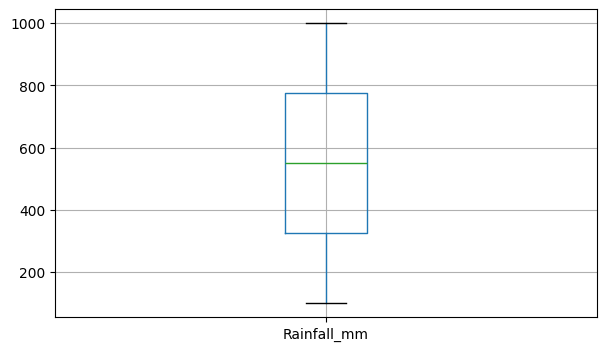

In [227]:
plt.figure(figsize=(7, 4))
df_crop_yield[['Rainfall_mm']].boxplot()
plt.xticks(rotation=0)
plt.show()

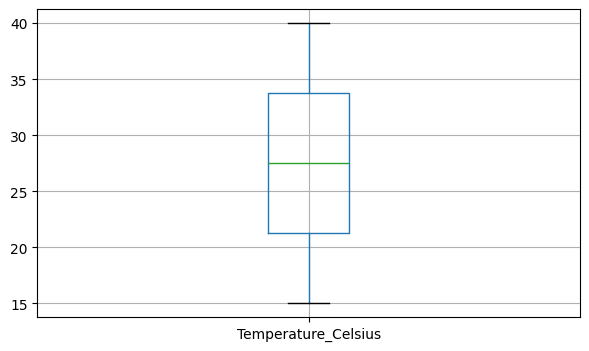

In [228]:
plt.figure(figsize=(7, 4))
df_crop_yield[['Temperature_Celsius']].boxplot()
plt.xticks(rotation=0)
plt.show()

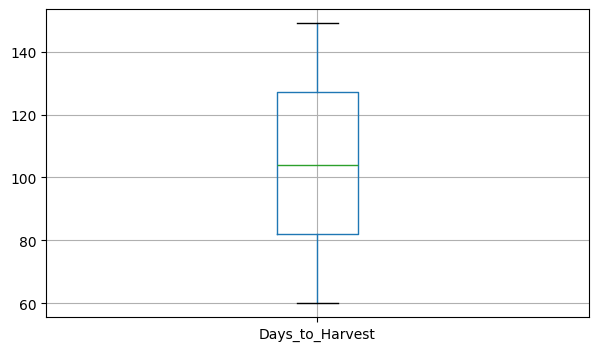

In [229]:
plt.figure(figsize=(7, 4))
df_crop_yield[['Days_to_Harvest']].boxplot()
plt.xticks(rotation=0)
plt.show()

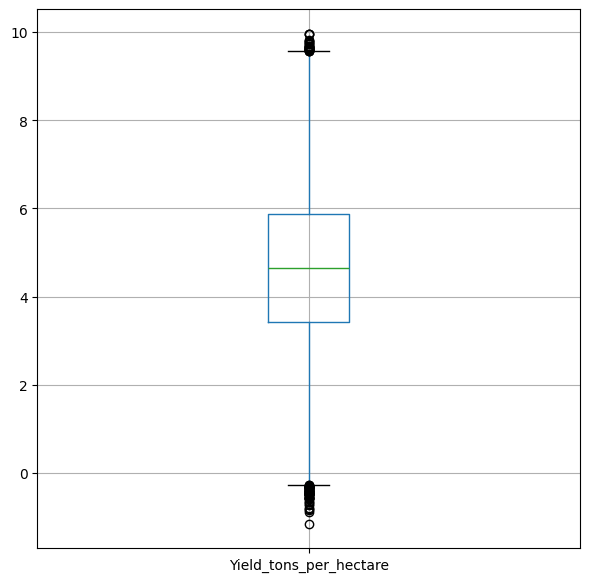

In [230]:
plt.figure(figsize=(7, 7))
df_crop_yield[['Yield_tons_per_hectare']].boxplot()
plt.xticks(rotation=0)
plt.show()

In [231]:
Q1 = df_crop_yield['Yield_tons_per_hectare'].quantile(0.25)
Q3 = df_crop_yield['Yield_tons_per_hectare'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_crop_yield[(df_crop_yield['Yield_tons_per_hectare'] < lower_bound) | (df_crop_yield['Yield_tons_per_hectare'] > upper_bound)]
outliers

Rainfall_mm  Temperature_Celsius  Fertilizer_Used  Irrigation_Used  \
11596    957.380991            36.324216             True             True   
39669    147.755191            20.390486            False            False   
54745    119.136310            15.984143            False            False   
77504    120.422223            22.809881            False            False   
93760    108.811480            17.936402            False            False   
...             ...                  ...              ...              ...   
942403   987.281001            23.821032             True             True   
947118   110.727929            23.191667            False            False   
949892   107.476604            15.473496            False            False   
966078   948.730680            38.383078             True             True   
975666   116.114046            16.257818            False            False   

        Weather_Condition  Days_to_Harvest  Yield_tons_per_hectare  \
11596                   2               73                9.727004   
39669                   1               72               -0.469229   
54745                   1               93               -0.290180   
77504                   0              120               -0.841617   
93760                   0               88               -0.434482   
...                   ...              ...                     ...   
942403                  0              114                9.826285   
947118                  0               80               -0.507013   
949892                  2               80               -0.309650   
966078                  1               82                9.650875   
975666                  2               70               -0.471038   

        Region_East  Region_North  Region_South  ...  Soil_Type_Loam  \
11596         False         False         False  ...           False   
39669          True         False         False  ...            True   
54745         False          True         False  ...           False   
77504         False         False         False  ...           False   
93760         False         False         False  ...           False   
...             ...           ...           ...  ...             ...   
942403        False         False          True  ...           False   
947118        False          True         False  ...           False   
949892        False          True         False  ...           False   
966078        False         False          True  ...           False   
975666        False         False          True  ...           False   

        Soil_Type_Peaty  Soil_Type_Sandy  Soil_Type_Silt  Crop_Barley  \
11596              True            False           False        False   
39669             False            False           False         True   
54745              True            False           False         True   
77504             False             True           False        False   
93760             False            False           False        False   
...                 ...              ...             ...          ...   
942403            False            False            True        False   
947118            False            False           False        False   
949892            False            False            True        False   
966078            False            False           False        False   
975666            False            False           False         True   

        Crop_Cotton  Crop_Maize  Crop_Rice  Crop_Soybean  Crop_Wheat  
11596         False       False      False         False        True  
39669         False       False      False         False       False  
54745         False       False      False         False       False  
77504         False       False      False         False        True  
93760         False       False      False          True       False  
...             ...         ...        ...           ...      

In [232]:
negatives = df_crop_yield[(df_crop_yield['Yield_tons_per_hectare'] < 0)]
negatives

Rainfall_mm  Temperature_Celsius  Fertilizer_Used  Irrigation_Used  \
756      101.019421            33.804131            False            False   
7799     108.804894            18.004082            False            False   
8421     168.120735            38.473430            False            False   
9553     156.607973            16.610257            False            False   
15435    177.481344            27.719742            False            False   
...             ...                  ...              ...              ...   
975666   116.114046            16.257818            False            False   
982738   235.792353            31.699429            False            False   
987054   100.467398            15.735951            False            False   
995837   105.575189            15.864764            False            False   
998040   184.671094            29.176601            False            False   

        Weather_Condition  Days_to_Harvest  Yield_tons_per_hectare  \
756                     0              117               -0.007103   
7799                    2               86               -0.061283   
8421                    1              111               -0.119911   
9553                    2              129               -0.193093   
15435                   2               94               -0.009811   
...                   ...              ...                     ...   
975666                  2               70               -0.471038   
982738                  2               68               -0.255772   
987054                  0               96               -0.120282   
995837                  0              111               -0.051633   
998040                  2               92               -0.125976   

        Region_East  Region_North  Region_South  ...  Soil_Type_Loam  \
756            True         False         False  ...           False   
7799          False         False          True  ...           False   
8421           True         False         False  ...           False   
9553          False          True         False  ...           False   
15435         False         False          True  ...           False   
...             ...           ...           ...  ...             ...   
975666        False         False          True  ...           False   
982738        False         False         False  ...            True   
987054        False         False         False  ...           False   
995837         True         False         False  ...           False   
998040        False          True         False  ...           False   

        Soil_Type_Peaty  Soil_Type_Sandy  Soil_Type_Silt  Crop_Barley  \
756                True            False           False        False   
7799              False            False           False        False   
8421              False            False           False        False   
9553              False            False            True        False   
15435             False            False           False        False   
...                 ...              ...             ...          ...   
975666            False            False           False         True   
982738            False            False           False        False   
987054             True            False           False         True   
995837            False            False           False        False   
998040            False            False           False        False   

        Crop_Cotton  Crop_Maize  Crop_Rice  Crop_Soybean  Crop_Wheat  
756            True       False      False         False       False  
7799          False       False       True         False       False  
8421          False       False      False          True       False  
9553          False       False      False         False        True  
15435         False        True      False         False       False  
...             ...         ...        ...           ...      

Rainfall, temperature and days-to-harvest are all within normal ranges, and thus do not require processing besides scaling. Yield in tons per hectare, on the other hand, has 84 outliers and 231 negative numbers, some of which are subset of the outliers. We will drop the outliers and negative numbers sequentially.

In [233]:
df_crop_yield = df_crop_yield.drop(outliers.index)
df_crop_yield.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999916 entries, 0 to 999999
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Rainfall_mm             999916 non-null  float64
 1   Temperature_Celsius     999916 non-null  float64
 2   Fertilizer_Used         999916 non-null  bool   
 3   Irrigation_Used         999916 non-null  bool   
 4   Weather_Condition       999916 non-null  int64  
 5   Days_to_Harvest         999916 non-null  int64  
 6   Yield_tons_per_hectare  999916 non-null  float64
 7   Region_East             999916 non-null  bool   
 8   Region_North            999916 non-null  bool   
 9   Region_South            999916 non-null  bool   
 10  Region_West             999916 non-null  bool   
 11  Soil_Type_Chalky        999916 non-null  bool   
 12  Soil_Type_Clay          999916 non-null  bool   
 13  Soil_Type_Loam          999916 non-null  bool   
 14  Soil_Type_Peaty         9

In [234]:
negatives = df_crop_yield[(df_crop_yield['Yield_tons_per_hectare'] < 0)]
df_crop_yield = df_crop_yield.drop(negatives.index)
df_crop_yield.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999741 entries, 0 to 999999
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Rainfall_mm             999741 non-null  float64
 1   Temperature_Celsius     999741 non-null  float64
 2   Fertilizer_Used         999741 non-null  bool   
 3   Irrigation_Used         999741 non-null  bool   
 4   Weather_Condition       999741 non-null  int64  
 5   Days_to_Harvest         999741 non-null  int64  
 6   Yield_tons_per_hectare  999741 non-null  float64
 7   Region_East             999741 non-null  bool   
 8   Region_North            999741 non-null  bool   
 9   Region_South            999741 non-null  bool   
 10  Region_West             999741 non-null  bool   
 11  Soil_Type_Chalky        999741 non-null  bool   
 12  Soil_Type_Clay          999741 non-null  bool   
 13  Soil_Type_Loam          999741 non-null  bool   
 14  Soil_Type_Peaty         9

In [235]:
# Sanity Check 4: Check final shape of crop yield dataframe
assert df_crop_yield.shape == (999741, 23), f"expected (999741, 23), but got {df_crop_yield.shape}"
tests_passed += 1
print ("4. Tests Passed")

4. Tests Passed


### Standard Scaling Numerical Columns

In [236]:
# We will keep non-zero matrix for NMF analysis
df_non_negative = pd.DataFrame.copy(df_crop_yield)

In [237]:
columns_to_scale = ['Rainfall_mm','Temperature_Celsius','Days_to_Harvest','Yield_tons_per_hectare']
scaler = StandardScaler()
df_crop_yield[columns_to_scale] = scaler.fit_transform(df_crop_yield[columns_to_scale])

df_crop_yield

Rainfall_mm  Temperature_Celsius  Fertilizer_Used  Irrigation_Used  \
0          1.335693             0.023691            False             True   
1          1.703656            -1.312907             True             True   
2         -1.547616             0.316897            False            False   
3          1.681304            -1.504301            False             True   
4          0.694050             0.569880             True             True   
...             ...                  ...              ...              ...   
999995    -0.951741             0.066689            False            False   
999996     1.473932             1.683434             True            False   
999997     1.221315            -0.434304             True            False   
999998    -0.220376             0.767211            False            False   
999999    -1.420832            -0.028677             True            False   

        Weather_Condition  Days_to_Harvest  Yield_tons_per_hectare  \
0                       1         0.674483                1.124123   
1                       0         1.368039                2.287279   
2                       2         0.057989               -2.078496   
3                       0         1.599225                1.101561   
4                       1         0.212113                1.532645   
...                   ...              ...                     ...   
999995                  2        -1.097938               -1.948617   
999996                  0        -0.442913                1.570016   
999997                  1         0.135051                0.656487   
999998                  2        -0.096135               -1.522315   
999999                  2        -1.097938               -1.010754   

        Region_East  Region_North  Region_South  ...  Soil_Type_Loam  \
0             False         False         False  ...           False   
1             False         False          True  ...           False   
2             False          True         False  ...            True   
3             False          True         False  ...           False   
4             False         False          True  ...           False   
...             ...           ...           ...  ...             ...   
999995        False         False         False  ...           False   
999996        False         False          True  ...           False   
999997        False          True         False  ...           False   
999998        False         False         False  ...           False   
999999        False         False         False  ...           False   

        Soil_Type_Peaty  Soil_Type_Sandy  Soil_Type_Silt  Crop_Barley  \
0                 False             True           False        False   
1                 False            False           False        False   
2                 False            False           False         True   
3                 False             True           False        False   
4                 False            False            True        False   
...                 ...              ...             ...          ...   
999995            False            False            True        False   
999996            False            False           False         True   
999997             True            False           False        False   
999998            False            False            True        False   
999999            False             True           False        False   

        Crop_Cotton  Crop_Maize  Crop_Rice  Crop_Soybean  Crop_Wheat  
0              True       False      False         False       False  
1             False       False       True         False       False  
2             False       False      False         False       False  
3             False       False      False          True       False  
4             False       False      False         False        True  
...             ...         ...        ...           ...      

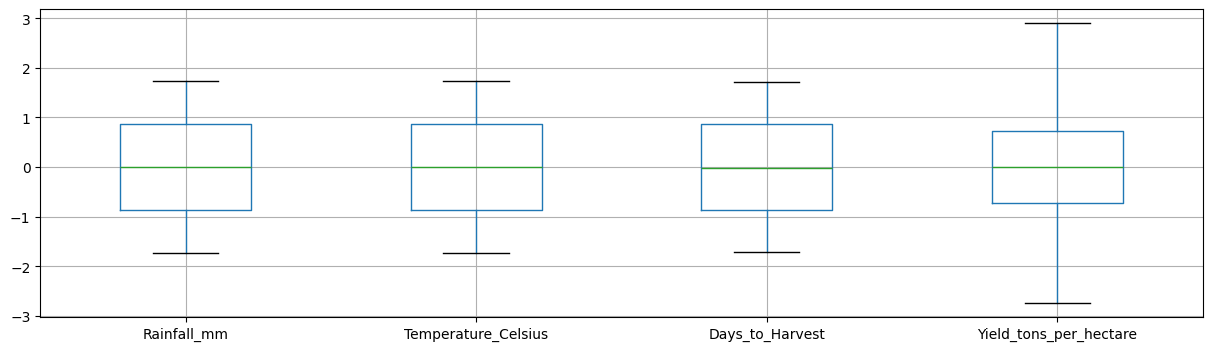

In [238]:
plt.figure(figsize=(15, 4))
df_crop_yield[['Rainfall_mm','Temperature_Celsius','Days_to_Harvest','Yield_tons_per_hectare']].boxplot()
plt.xticks(rotation=0)
plt.show()

### Random Sample and Balance Labels

In [239]:
df_crop_yield = df_crop_yield.sample(10000, random_state=42)
df_crop_yield

Rainfall_mm  Temperature_Celsius  Fertilizer_Used  Irrigation_Used  \
517655    -1.323994            -1.031876             True             True   
756521     0.171972             0.609267            False             True   
655545     1.053462            -0.094079            False             True   
163503    -0.364239             1.172926            False            False   
138977     1.407222             1.071905            False             True   
...             ...                  ...              ...              ...   
366471     0.545313             0.120286            False             True   
597303     1.421486             1.360510             True             True   
933086    -1.562849             1.049316             True             True   
704945    -0.717055             0.005245            False            False   
499232     0.785097             1.244035            False             True   

        Weather_Condition  Days_to_Harvest  Yield_tons_per_hectare  \
517655                  1         0.520360               -0.390588   
756521                  1         0.250643                0.328831   
655545                  1        -0.751160                1.009457   
163503                  2         1.676287               -0.440961   
138977                  2         0.944200                1.073729   
...                   ...              ...                     ...   
366471                  2         0.597422                0.625946   
597303                  0        -1.483247                2.382218   
933086                  0         0.520360               -0.232247   
704945                  0        -0.828222               -1.310048   
499232                  0         0.790076                0.346974   

        Region_East  Region_North  Region_South  ...  Soil_Type_Loam  \
517655         True         False         False  ...           False   
756521        False         False         False  ...           False   
655545        False         False         False  ...           False   
163503         True         False         False  ...           False   
138977        False         False          True  ...           False   
...             ...           ...           ...  ...             ...   
366471         True         False         False  ...           False   
597303         True         False         False  ...           False   
933086        False          True         False  ...           False   
704945        False         False          True  ...           False   
499232        False          True         False  ...           False   

        Soil_Type_Peaty  Soil_Type_Sandy  Soil_Type_Silt  Crop_Barley  \
517655             True            False           False        False   
756521            False            False           False        False   
655545             True            False           False        False   
163503            False            False           False        False   
138977            False            False           False        False   
...                 ...              ...             ...          ...   
366471            False            False            True         True   
597303            False            False           False        False   
933086            False            False           False        False   
704945            False            False            True         True   
499232            False            False           False         True   

        Crop_Cotton  Crop_Maize  Crop_Rice  Crop_Soybean  Crop_Wheat  
517655        False       False       True         False       False  
756521        False       False      False          True       False  
655545        False       False       True         False       False  
163503        False       False       True         False       False  
138977        False        True      False         False       False  
...             ...         ...        ...           ...      

In [240]:
df_non_negative = df_non_negative.loc[df_crop_yield.index]
df_non_negative

Rainfall_mm  Temperature_Celsius  Fertilizer_Used  Irrigation_Used  \
517655   206.094584            20.055304             True             True   
756521   594.744256            31.905080            False             True   
655545   823.753867            26.826612            False             True   
163503   455.437452            35.974947            False            False   
138977   915.660191            35.245533            False             True   
...             ...                  ...              ...              ...   
366471   691.737757            28.374421            False             True   
597303   919.366141            37.329383             True             True   
933086   144.040308            35.082429             True             True   
704945   363.776363            27.543774            False            False   
499232   754.033151            36.488386            False             True   

        Weather_Condition  Days_to_Harvest  Yield_tons_per_hectare  \
517655                  1              118                3.988413   
756521                  1              111                5.207813   
655545                  1               85                6.361459   
163503                  2              148                3.903031   
138977                  2              129                6.470399   
...                   ...              ...                     ...   
366471                  2              120                5.711415   
597303                  0               66                8.688260   
933086                  0              118                4.256797   
704945                  0               83                2.429946   
499232                  0              125                5.238565   

        Region_East  Region_North  Region_South  ...  Soil_Type_Loam  \
517655         True         False         False  ...           False   
756521        False         False         False  ...           False   
655545        False         False         False  ...           False   
163503         True         False         False  ...           False   
138977        False         False          True  ...           False   
...             ...           ...           ...  ...             ...   
366471         True         False         False  ...           False   
597303         True         False         False  ...           False   
933086        False          True         False  ...           False   
704945        False         False          True  ...           False   
499232        False          True         False  ...           False   

        Soil_Type_Peaty  Soil_Type_Sandy  Soil_Type_Silt  Crop_Barley  \
517655             True            False           False        False   
756521            False            False           False        False   
655545             True            False           False        False   
163503            False            False           False        False   
138977            False            False           False        False   
...                 ...              ...             ...          ...   
366471            False            False            True         True   
597303            False            False           False        False   
933086            False            False           False        False   
704945            False            False            True         True   
499232            False            False           False         True   

        Crop_Cotton  Crop_Maize  Crop_Rice  Crop_Soybean  Crop_Wheat  
517655        False       False       True         False       False  
756521        False       False      False          True       False  
655545        False       False       True         False       False  
163503        False       False       True         False       False  
138977        False        True      False         False       False  
...             ...         ...        ...           ...      

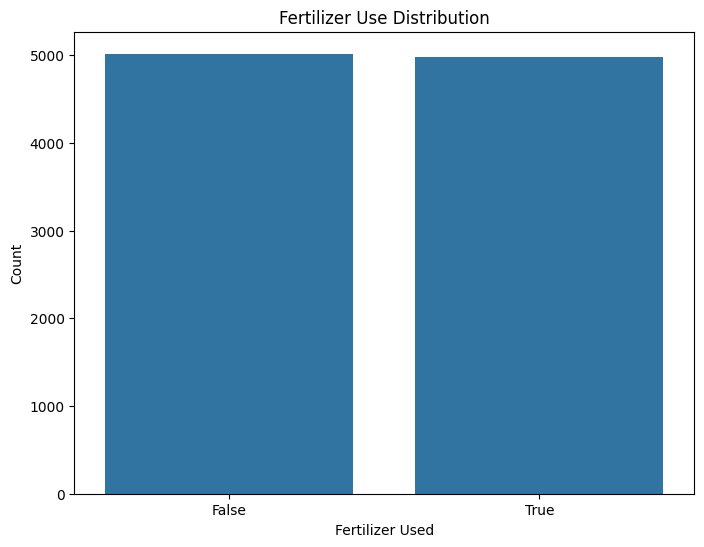

In [241]:
class_counts = df_crop_yield.Fertilizer_Used.value_counts()

# bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Fertilizer Use Distribution')
plt.xlabel('Fertilizer Used')
plt.ylabel('Count')
plt.show()

Target labels are fairly balanced, so we will leave it as is.

### Separate Target Labels

In [242]:
df_labels = df_crop_yield.Fertilizer_Used
df_crop_yield = df_crop_yield.drop(columns=['Fertilizer_Used'])

df_labels_nn = df_non_negative.Fertilizer_Used
df_non_negative = df_non_negative.drop(columns=['Fertilizer_Used'])

In [243]:
df_labels

517655     True
756521    False
655545    False
163503    False
138977    False
          ...  
366471    False
597303     True
933086     True
704945    False
499232    False
Name: Fertilizer_Used, Length: 10000, dtype: bool

In [244]:
# confirm labels were extracted and print unique target labels
print(sorted(df_labels.unique()))

[False, True]


In [245]:
# confirm that labels have been dropped
df_crop_yield

Rainfall_mm  Temperature_Celsius  Irrigation_Used  Weather_Condition  \
517655    -1.323994            -1.031876             True                  1   
756521     0.171972             0.609267             True                  1   
655545     1.053462            -0.094079             True                  1   
163503    -0.364239             1.172926            False                  2   
138977     1.407222             1.071905             True                  2   
...             ...                  ...              ...                ...   
366471     0.545313             0.120286             True                  2   
597303     1.421486             1.360510             True                  0   
933086    -1.562849             1.049316             True                  0   
704945    -0.717055             0.005245            False                  0   
499232     0.785097             1.244035             True                  0   

        Days_to_Harvest  Yield_tons_per_hectare  Region_East  Region_North  \
517655         0.520360               -0.390588         True         False   
756521         0.250643                0.328831        False         False   
655545        -0.751160                1.009457        False         False   
163503         1.676287               -0.440961         True         False   
138977         0.944200                1.073729        False         False   
...                 ...                     ...          ...           ...   
366471         0.597422                0.625946         True         False   
597303        -1.483247                2.382218         True         False   
933086         0.520360               -0.232247        False          True   
704945        -0.828222               -1.310048        False         False   
499232         0.790076                0.346974        False          True   

        Region_South  Region_West  ...  Soil_Type_Loam  Soil_Type_Peaty  \
517655         False        False  ...           False             True   
756521         False         True  ...           False            False   
655545         False         True  ...           False             True   
163503         False        False  ...           False            False   
138977          True        False  ...           False            False   
...              ...          ...  ...             ...              ...   
366471         False        False  ...           False            False   
597303         False        False  ...           False            False   
933086         False        False  ...           False            False   
704945          True        False  ...           False            False   
499232         False        False  ...           False            False   

        Soil_Type_Sandy  Soil_Type_Silt  Crop_Barley  Crop_Cotton  Crop_Maize  \
517655            False           False        False        False       False   
756521            False           False        False        False       False   
655545            False           False        False        False       False   
163503            False           False        False        False       False   
138977            False           False        False        False        True   
...                 ...             ...          ...          ...         ...   
366471            False            True         True        False       False   
597303            False           False        False        False       False   
933086            False           False        False        False       False   
704945            False            True         True        False       False   
499232            False           False         True        False       False   

        Crop_Rice  Crop_Soybean  Crop_Wheat  
517655       True         False       False  
756521      False          True       False  
655545       True         False       False  
163503       True         False       False  
138977

In [246]:
# Sanity Check 5: Check labels shape and (-)labels crop yield dataframe shape
assert df_labels.shape == (10000,), f"expected (10000,), but got {df_labels.shape}"
assert df_crop_yield.shape == (10000, 22), f"expected (10000, 22), but got {df_crop_yield.shape}"
tests_passed += 1
print ("5. Tests Passed")

5. Tests Passed


### Data Cleaning and EDA Conclusion

For this EDA, we took several steps to ensure robustness and usability of the agriculture dataset. We started out with one-hot encoding region, soil type, and crop, all of which are non-ordinal categorical data. Next, average weather condition was transformed into an ordinal ranking to capture relationship between cloud cover and sunlight. We then conducted an outlier analysis on the numerical features: rainfall, temperature, days to harvest and crop yield. This enabled us to identify outliers and negative values in crop yield that were dropped from the data. Afterwards, standard scaling was employed to normalize the numerical data. To make this notebook computationally manageable, 10000 data points were sampled from the original 1 million. Finally, we checked for class imbalance in fertilizer use, ensuring the dataset was suitable for further analysis.

## Model Building and Training

### Split Data for Train and Validation Sets

Since we have a dense dataset, we will use a 70-30 train-validation split  

In [247]:
X_train, X_test, y_train, y_test = train_test_split(df_crop_yield, df_labels, test_size=0.3, random_state=42)

In [248]:
X_train_nmf = df_non_negative.loc[X_train.index]
X_test_nmf = df_non_negative.loc[X_test.index]
y_train_nmf = df_labels_nn.loc[y_train.index]
y_test_nmf = df_labels_nn.loc[y_test.index]

In [249]:
# We will keep track of accuracy, precision and recall of each model for summary statistics
summary_stats = {
    'Model': [],
    'Train Accuracy': [],
    'Train Precision': [],
    'Train Recall': [],
    'Test Accuracy': [],
    'Test Precision': [],
    'Test Recall': [],
    'P-Value': [],
    'Is Significant': []
}

In [250]:
unique_labels = sorted(list(y_train.unique()))

# Helper function from CSCA 5632 Week 2 Lab
def label_permute_compare(ytdf,yp,n=2):
    permutations = list(itertools.permutations(range(n)))
    
    max_acc = float('-inf')
    permutation_ = None
    prediction_ = None
    
    for permutation in permutations:
        cluster_to_index = np.take(permutation, yp)
        prediction = np.take(unique_labels, cluster_to_index)
        
        acc = sum(ytdf == prediction)/ytdf.shape[0]
        if acc > max_acc:
            max_acc = acc
            permutation_ = permutation
            prediction_ = prediction

    return permutation_, max_acc

In [251]:
def XOR(a, b):
    return (a and not b) or (not a and b)
    
# Generalized Statistics Handling. Probably bad practice, but notebook looks much cleaner :) Saved about a few hundreds of lines of code (?)
def handle_stats(predictor=None, model_name=None, _prediction=None, is_test=True, permute_labels=False):
    assert model_name is not None, "Please provide model name"
    assert XOR(predictor is not None, _prediction is not None), "Either provide a predictor or a prediction, and not both."
    
    ### Prepare predictions
    prediction = None
    if predictor is not None and is_test:
        prediction = predictor.predict(X_test)
    elif predictor is not None and not is_test:
        prediction = predictor.predict(X_train)
    else:
        prediction = _prediction
        
    ### Prepare labels
    labels = np.array(y_test) if is_test else np.array(y_train)

    ### Permute labels if necessary (for clustering methods)
    if permute_labels:
        labelorder, acc = label_permute_compare(labels, prediction)
        cluster_to_index = np.take(labelorder, prediction)
        prediction = np.take(unique_labels, cluster_to_index)

    print(f"Prediction: {prediction}, shape: {prediction.shape} \n")
    print(f"True Label: {labels}, shape: {labels.shape} \n")
    
    # Calculate Accuracy
    total = len(np.array(prediction == labels))
    correct = len(np.where(np.array(prediction == labels) == True)[0])
    accuracy = correct/total
    
    # Construct confusion matrix
    confusion_mat = confusion_matrix(labels, prediction)
    
    # Calculate Precision
    _precision = precision(confusion_mat)
    # Calculate Recall
    _recall = recall(confusion_mat)

    # Calculate p-value assuming binomial probability distribution for n = |label|
    p = 0.5
    mean = p * len(labels) 
    std = np.sqrt(len(labels) * p * (1-p))
    observed_accuracy = accuracy * len(labels)
    
    # Calculate the z-score
    z_score = (observed_accuracy - mean) / std
    
    # Calculate the p-value (two-tailed)
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))
    
    print(f"Z-Score: {z_score} \n")
    print(f"P-Value: {p_value} \n")
    
    summary_stats['P-Value'].append(p_value)
    summary_stats['Is Significant'].append(True) if p_value < 0.05 else summary_stats['Is Significant'].append(False)
    
    summary_stats['Model'].append(model_name)

    print(confusion_mat)

    ###
    prefix = "est" if is_test else "rain"
    antiprefix = "rain" if is_test else "est"
    
    print(f"t{prefix} accuracy: {accuracy}")
    print(f"t{prefix} precision: {_precision}")
    print(f"t{prefix} recall: {_recall}")

    summary_stats[f'T{prefix} Accuracy'].append(accuracy)
    summary_stats[f'T{prefix} Precision'].append(_precision)
    summary_stats[f'T{prefix} Recall'].append(_recall)
    summary_stats[f'T{antiprefix} Accuracy'].append(None)
    summary_stats[f'T{antiprefix} Precision'].append(None)
    summary_stats[f'T{antiprefix} Recall'].append(None)

# handle_stats(predictor=None, model_name=None, _prediction=None, is_test=True, permute_labels=False)

### Hierarchical Clustering

*Here we will do some hyperparameter tuning for hierarchical clustering*

In [252]:
metrics = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
linkages = ['ward', 'complete', 'average', 'single']

max_acc = float('-inf')
best_confusion_mat = None
best_metric = None
best_linkage = None
best_model = None
best_prediction = None

for metric_ in metrics:
    for linkage_ in linkages:
        if linkage_ == 'ward' and metric_ != 'euclidean':
            continue
            
        model=AgglomerativeClustering(n_clusters=2, metric=metric_, linkage=linkage_)
        model.fit(X_train)
        labelorder, acc = label_permute_compare(y_train, model.labels_)
        
        cluster_to_index = np.take(labelorder, model.labels_)
        prediction = np.take(unique_labels, cluster_to_index)
        confusion_matrix_ = confusion_matrix(np.array(y_train), prediction, labels=unique_labels)
        
        if acc > max_acc:
            max_acc = acc
            confusion_mat = confusion_matrix_
            best_metric = metric_
            best_linkage = linkage_
            best_model = model
            best_prediction = prediction

print(best_metric, best_linkage, max_acc)

l1 complete 0.5708571428571428


In [253]:
handle_stats(predictor=None, model_name="Hierarchical Clustering", _prediction=best_prediction, is_test=False, permute_labels=False)

Prediction: [False False False ... False False False], shape: (7000,) 

True Label: [False False False ...  True  True  True], shape: (7000,) 

Z-Score: 11.856667804597183 

P-Value: 0.0 

[[1894 1596]
 [1408 2102]]
train accuracy: 0.5708571428571428
train precision: 0.5710035611110037
train recall: 0.5707769043012596


### Cluster Visualization

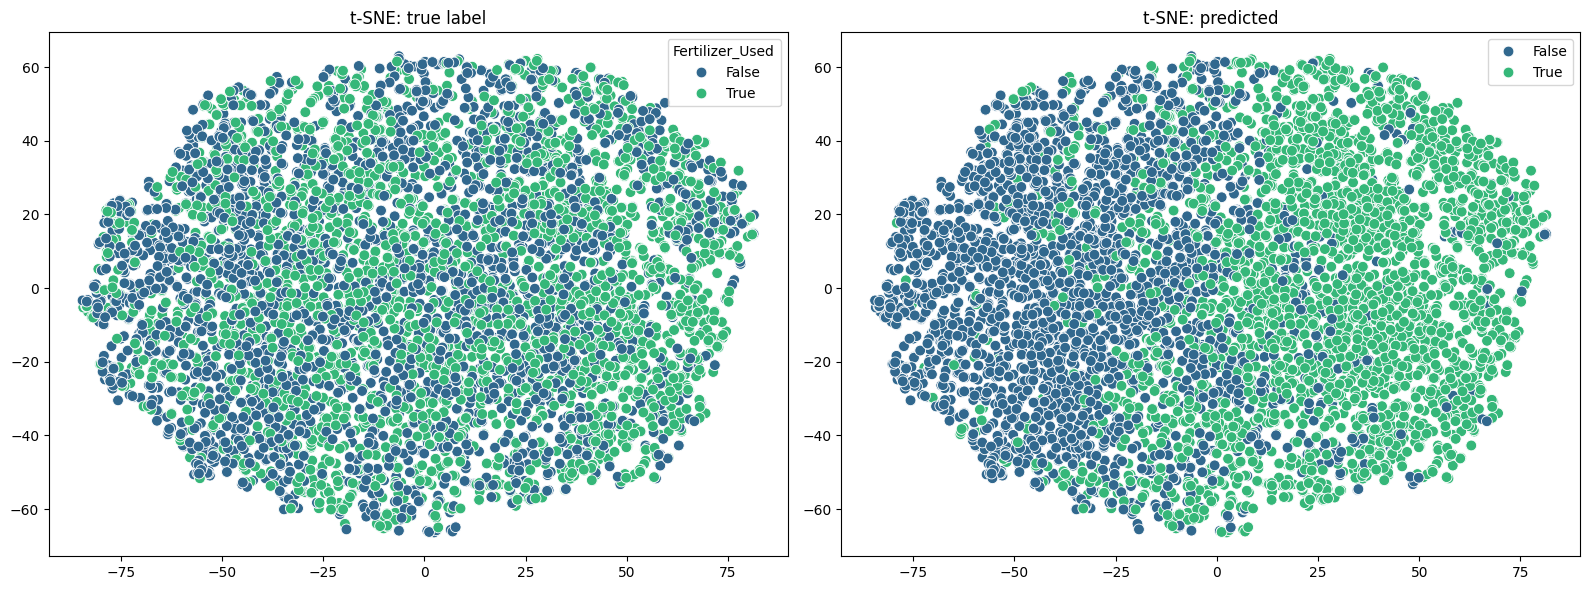

In [254]:
from sklearn.manifold import TSNE

# fit-transform t-SNE on the training data
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# plot 1: training labels
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_train, palette='viridis', s=60, ax=ax[0])
ax[0].set_title('t-SNE: true label')

# plot 2: predicted labels
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=best_prediction, palette='viridis', s=60, ax=ax[1])
ax[1].set_title('t-SNE: predicted')

plt.tight_layout()
plt.show()

Here, we applied t-SNE for preliminary cluster visualization. The resulting scatter plot of true labels revealed that data points are evenly interspersed, suggesting a random distribution of labels with no clear clustering. However, statistics from hierarchical clustering indicates significant predictability in fertilizer use patterns, hinting that underlying structure exists despite the visualization. This motivates further exploration using other visualization methods, coupled with PCA, to enhance interpretability and uncover more meaningful patterns.

### Further Visualization and PCA

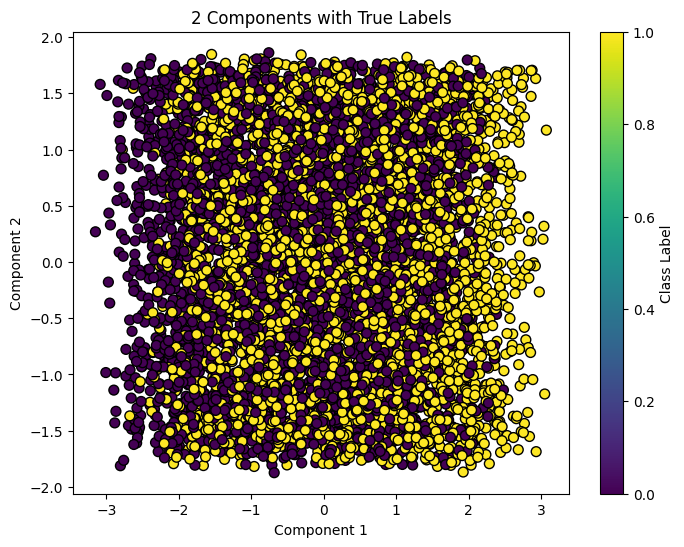

In [255]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', edgecolor='k', s=50)
plt.title('2 Components with True Labels')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(label='Class Label')
plt.show()

This scatterplot, unlike the previous t-SNE plot, shows clear linear separability between the two class labels. However, it is evident that only small portions at the extreme ends of the first component are well-separated, while much of the data are randomly distributed in the middle. This explains why we have significant accuracy from clustering, yet the predictive power for classification remains disappointingly low. Next, we will explore higher dimensions to check for additional linear separability.

[0.99578492 0.94999263 0.51808634 ... 0.07939043 0.07346795 0.06022931]


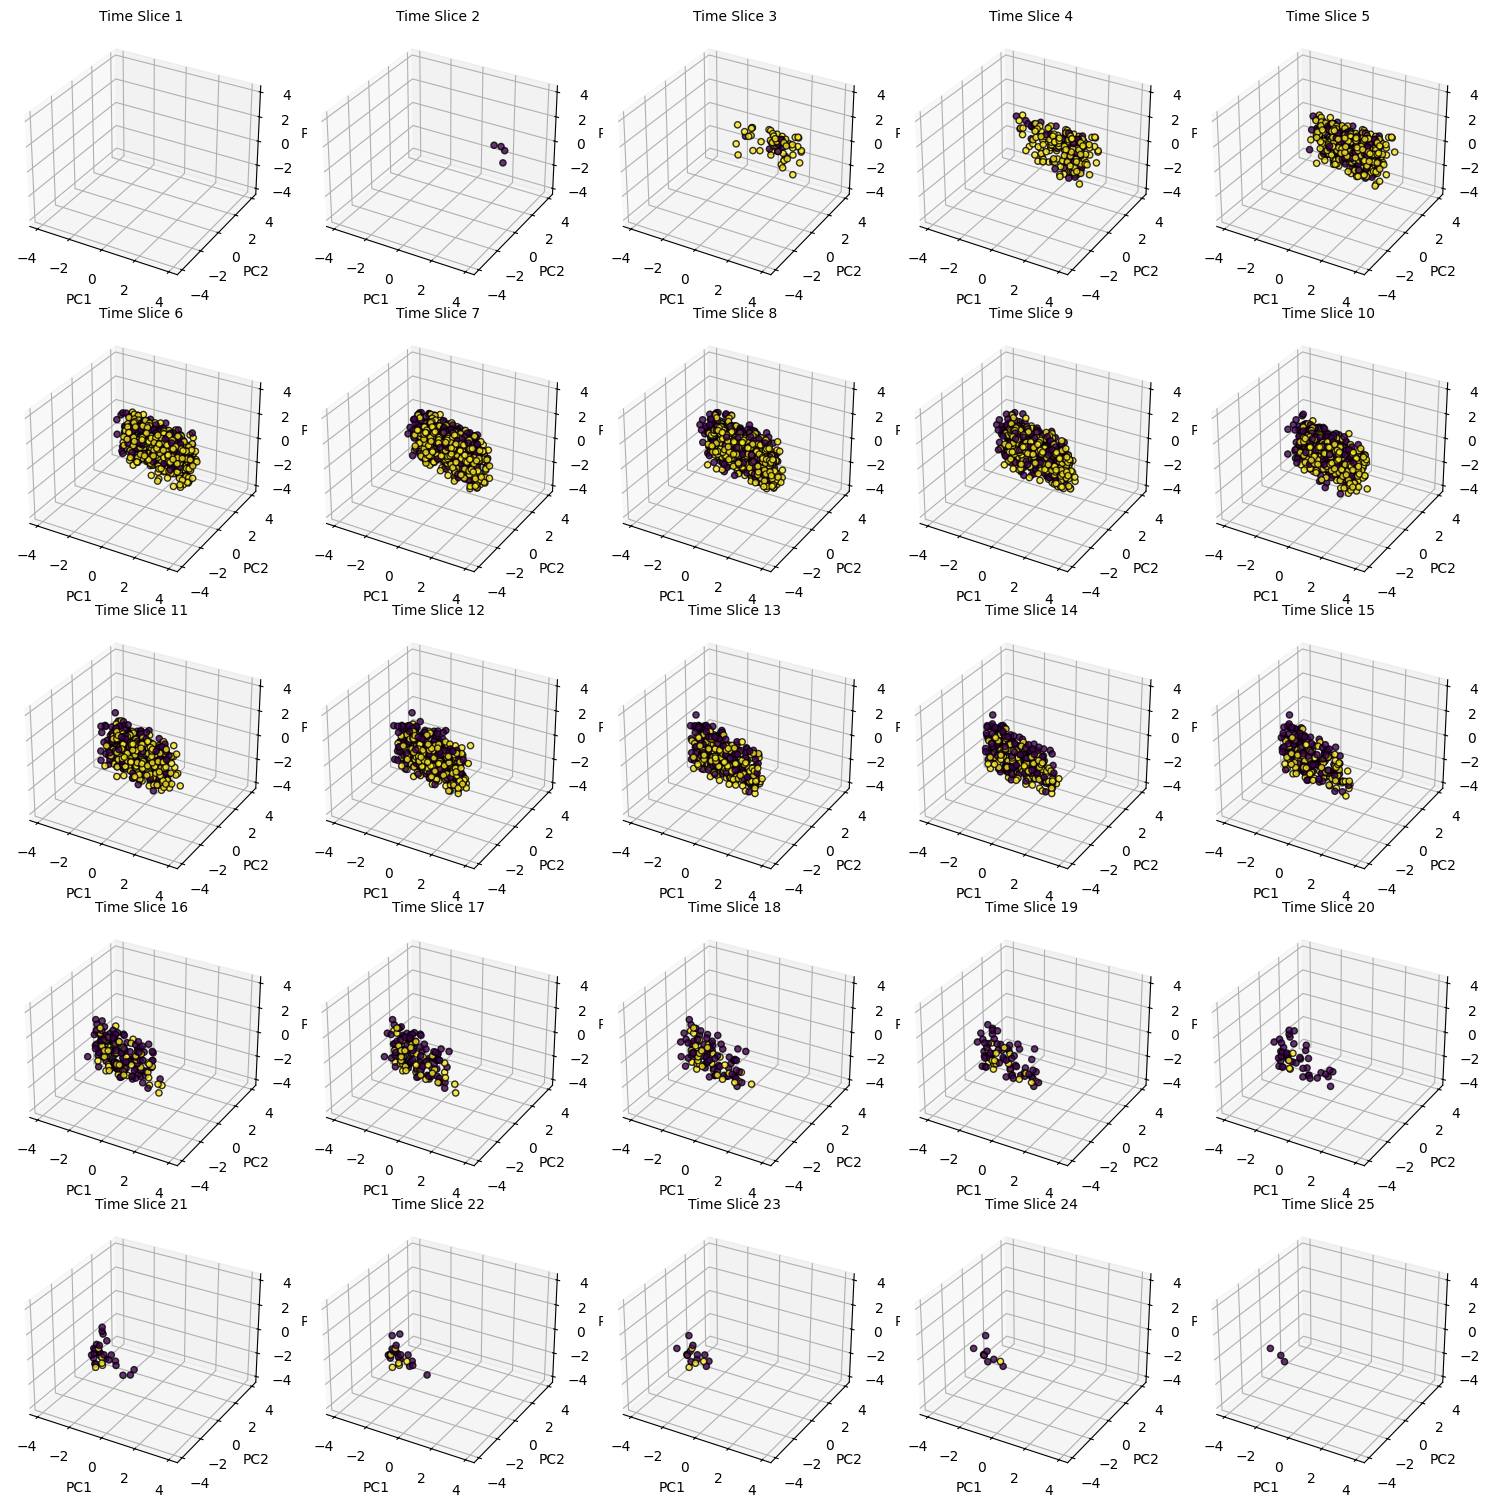

In [256]:
from matplotlib.animation import FuncAnimation
from sklearn.preprocessing import MinMaxScaler

# perform PCA for 4 components
pca = PCA(n_components=4)
X_train_pca = pca.fit_transform(X_train)

scaler = MinMaxScaler()
X_train_pca[:, 3] = scaler.fit_transform(X_train_pca[:, 3].reshape(-1, 1)).ravel()
print(X_train_pca[:, 3])

# Set up 5x5 grid
fig, axes = plt.subplots(5, 5, figsize=(15, 15), subplot_kw={'projection': '3d'})

# Loop over the grid to plot for different time points
for i, ax in enumerate(axes.flat):
    # Set fixed axis limits
    ax.set_xlim([-4.5, 4.5])
    ax.set_ylim([-4.5, 4.5])
    ax.set_zlim([-4.5, 4.5])
    
    # Define the condition based on the 4th PCA component for each time slice
    frame = i + 1
    condition = (X_train_pca[:, 3] < (np.log(frame+1))*0.05 - 0.05) & \
                (X_train_pca[:, 3] >= (np.log(frame-2))*0.05 - 0.05)

    subset = X_train_pca[condition]
    indices = np.where(condition)[0]

    if subset.size > 0:
        ax.scatter(subset[:, 0], subset[:, 1], subset[:, 2], 
                   c=np.array(y_train)[indices], cmap='viridis', s=20, edgecolors='k', alpha=0.8)

    ax.set_title(f'Time Slice {frame}', fontsize=10)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')

plt.tight_layout()
plt.show()


In this step, we plot a series of 3D scatterplots with the fourth component as time. The datapoints are binned to create meaningful progression from one time slice to another. Here we can see that class labels slowly transition from one class to another starting from one corner of a cubic structure to the opposite corner. Interestingly, this suggests that there is linear separability across not just one component but all three, unlike the scatter plot of 2-component PCA which reveals linear separability across only one component. Because the data shows linearity in multiple dimensions, it is most likely the case that linear models will perform just as well, if not better, than non-linear models. This also suggests that distance-based similarity metrics will be appropriate for clustering tasks. This is consistent with the fact that the best metric from hierarchical clustering was l1 norm. Next, we will confirm this by using K-Means Clustering, which is another distance-based clustering method. We will also try out other clustering methods that are used for non-linear data.

### K-Means Clustering

In [257]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=2)
model.fit(X_train)

handle_stats(predictor=model, model_name="K-Means Clustering", _prediction=None, is_test=True, permute_labels=True)

Prediction: [False False False ... False  True False], shape: (3000,) 

True Label: [False  True  True ... False  True False], shape: (3000,) 

Z-Score: 7.960234502408414 

P-Value: 1.7763568394002505e-15 

[[897 631]
 [651 821]]
test accuracy: 0.5726666666666667
test precision: 0.5724421807931321
test recall: 0.5723932250170727


### Linear Kernel SVC

In [258]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

parameters = {'loss': ['hinge', 'squared_hinge'],
              'C':np.logspace(-10, 10, 301, base=2)}
svc = LinearSVC(random_state=42)
grid_linsvc = GridSearchCV(svc, parameters, cv=5, n_jobs=-1, scoring='accuracy')

grid_linsvc.fit(X_train, y_train)

best_params = grid_linsvc.best_params_
best_score = grid_linsvc.best_score_

print(f"best params: {best_params}")
print(f"cross validation score: {best_score}")

best params: {'C': 30.554931325133335, 'loss': 'hinge'}
cross validation score: 0.9359999999999999


In [259]:
handle_stats(predictor=grid_linsvc.best_estimator_, model_name="Linear SVC", _prediction=None, is_test=True, permute_labels=False)

Prediction: [False False  True ... False  True False], shape: (3000,) 

True Label: [False  True  True ... False  True False], shape: (3000,) 

Z-Score: 47.10413994544428 

P-Value: 0.0 

[[1417  111]
 [  99 1373]]
test accuracy: 0.93
test precision: 0.9299493631275381
test recall: 0.9300502930799


### Spectral Clustering

In [260]:
from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(n_clusters=2, affinity='poly', random_state=42)
prediction = spectral.fit_predict(X_train)

handle_stats(predictor=None, model_name="Spectral Clustering", _prediction=prediction, is_test=False, permute_labels=True)

Prediction: [False False False ... False  True False], shape: (7000,) 

True Label: [False False False ...  True  True  True], shape: (7000,) 

Z-Score: 11.474194649610189 

P-Value: 0.0 

[[1885 1605]
 [1415 2095]]
train accuracy: 0.5685714285714286
train precision: 0.5687141687141687
train recall: 0.5684903550233062


### Gaussian Mixture Models

In [261]:
from sklearn.mixture import GaussianMixture

model_gmm = GaussianMixture(n_components=2)
model_gmm.fit(X_train)

handle_stats(predictor=model_gmm, model_name="Gaussian Mixture Models", _prediction=None, is_test=True, permute_labels=True)

Prediction: [False False  True ... False False False], shape: (3000,) 

True Label: [False  True  True ... False  True False], shape: (3000,) 

Z-Score: 1.8987715326845758 

P-Value: 0.057594521649053876 

[[800 728]
 [720 752]]
test accuracy: 0.5173333333333333
test precision: 0.5172119487908962
test recall: 0.5172148873207376


### Non-negative Matrix Factorization

In [262]:
from sklearn.decomposition import NMF
import itertools

In [263]:
inits = [None, 'random', 'nndsvd', 'nndsvda', 'nndsvdar', 'custom']
solvers = ['cd', 'mu']
beta_losses = ['frobenius', 'kullback-leibler', 'itakura-saito']

combinations = list(itertools.product(inits, solvers, beta_losses))

max_accuracy = float("-inf")
best_prediction = None
best_params = None


for init, solver, beta_loss in combinations:
    try:
        nmf = NMF(n_components=2,
                  init=init, 
                  solver = solver,
                  beta_loss = beta_loss,
                  random_state = 0)
        nmf.fit(X_train_nmf)

        nmf_test = nmf.transform(X_test_nmf)
        yp = np.argmax(nmf_test, axis=1)
        
        labelorder, acc = label_permute_compare(y_test_nmf, yp)
        print(init, solver, beta_loss)
        print(labelorder, acc, '\n')

        if acc > max_accuracy:
            max_accuracy = acc
            best_prediction = yp
            best_params = (init, solver, beta_loss)
    except:
        pass

print(best_params, max_accuracy)

None cd frobenius
(1, 0) 0.5103333333333333 

None mu frobenius
(1, 0) 0.5063333333333333 

None mu kullback-leibler
(1, 0) 0.5013333333333333 

random cd frobenius
(0, 1) 0.5146666666666667 

random mu frobenius
(0, 1) 0.506 

random mu kullback-leibler
(1, 0) 0.505 

nndsvd cd frobenius
(0, 1) 0.5066666666666667 

nndsvd mu frobenius
(0, 1) 0.506 

nndsvd mu kullback-leibler
(0, 1) 0.5083333333333333 

nndsvda cd frobenius
(1, 0) 0.5103333333333333 

nndsvda mu frobenius
(1, 0) 0.5063333333333333 

nndsvda mu kullback-leibler
(1, 0) 0.5013333333333333 

nndsvdar cd frobenius
(0, 1) 0.5066666666666667 

nndsvdar mu frobenius
(0, 1) 0.5066666666666667 

nndsvdar mu kullback-leibler
(0, 1) 0.5096666666666667 

('random', 'cd', 'frobenius') 0.5146666666666667


In [264]:
handle_stats(predictor=None, model_name="NMF", _prediction=best_prediction, is_test=True, permute_labels=True)

Prediction: [False False False ... False False False], shape: (3000,) 

True Label: [False  True  True ... False  True False], shape: (3000,) 

Z-Score: 1.6066528353484955 

P-Value: 0.10813054531150113 

[[1500   28]
 [1428   44]]
test accuracy: 0.5146666666666667
test precision: 0.5617030965391621
test recall: 0.5057833485089915


### K-Means Clustering with Autoencoder

In [265]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from keras.models import Model, Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam

In [275]:
import tensorflow as tf

In [300]:
tf.random.set_seed(42)

X_train_array = np.array(X_train, dtype=np.float32)

# Input dimensions
input_dim = X_train_array.shape[1]  
# Latent space dimensions
encoding_dim = 2  

input_layer = Input(shape=(input_dim,))
# Encoding layer
encoded = Dense(encoding_dim, activation='relu')(input_layer)  
# Decoding layer
decoded = Dense(input_dim, activation='sigmoid')(encoded)      

autoencoder = Model(input_layer, decoded)
# Separate model to extract latent features
encoder = Model(input_layer, encoded)

autoencoder.compile(optimizer=Adam(), loss='mse')

# Train Autoencoder
autoencoder.fit(X_train_array, X_train_array, epochs=50, batch_size=32, shuffle=True, verbose=1)

# Extract Latent Features
X_encoded = encoder.predict(X_train_array)

Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4518
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 0.3697
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - loss: 0.3231
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 0.3087
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - loss: 0.3019
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - loss: 0.2982
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 0.2956
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - loss: 0.2935
Epoch 9/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 0.2914
Epoch 10/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 0.2894
Epoch 11/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - loss: 0.2874
Epoch 12/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 0.2856
Epoch 13/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - loss: 0.2840
Epoch 14/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 0.2825
Epoch 15/50
219/219 ━━━━━━━━━━━

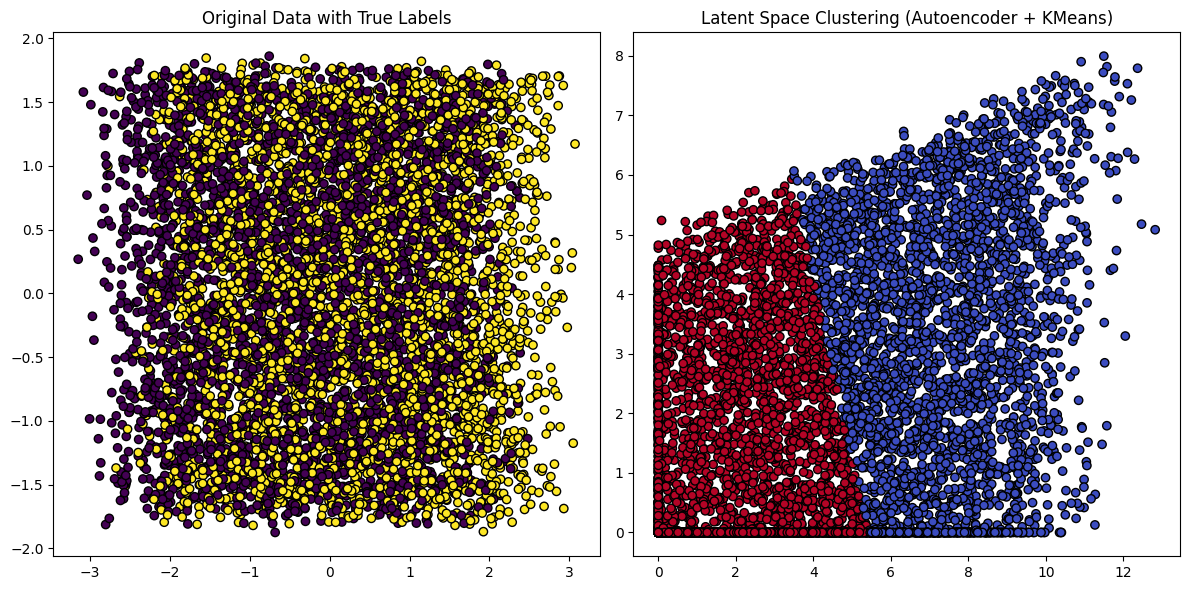

In [301]:
# Apply Clustering (KMeans) on Latent Space
kmeans = KMeans(n_clusters=2, random_state=42)
prediction = kmeans.fit_predict(X_encoded)

# Plot Results
plt.figure(figsize=(12, 6))

# Original data
plt.subplot(1, 2, 1)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', edgecolors='k')
plt.title('Original Data with True Labels')

# Latent space with cluster assignments
plt.subplot(1, 2, 2)
plt.scatter(X_encoded[:, 0], X_encoded[:, 1], c=prediction, cmap='coolwarm', edgecolors='k')
plt.title('Latent Space Clustering (Autoencoder + KMeans)')

plt.tight_layout()
plt.show()

In [302]:
handle_stats(predictor=None, model_name="K-Means + Autoencoder", _prediction=prediction, is_test=False, permute_labels=True)

Prediction: [False False False ... False  True False], shape: (7000,) 

True Label: [False False False ...  True  True  True], shape: (7000,) 

Z-Score: 10.56582090651604 

P-Value: 0.0 

[[1867 1623]
 [1435 2075]]
train accuracy: 0.5631428571428572
train precision: 0.5632645078994032
train recall: 0.5630625556126989


### Final Sanity Check

In [303]:
assert tests_passed == num_tests, f"{tests_passed} out of {num_tests} tests passed. {num_tests-tests_passed} cases failed. Please check test cases."
print("All Tests Passed")

All Tests Passed


## Results and Analysis

### Summary Statistics

In [305]:
# print(pd.DataFrame(summary_stats).round(3).to_markdown())
# pd.DataFrame(summary_stats).round(3)

|    | Model                   |   Train Accuracy |   Train Precision |   Train Recall |   Test Accuracy |   Test Precision |   Test Recall |   P-Value | Is Significant   |
|---:|:------------------------|-----------------:|------------------:|---------------:|----------------:|-----------------:|--------------:|----------:|:-----------------|
|  0 | Hierarchical Clustering |            0.571 |             0.571 |          0.571 |         nan     |          nan     |       nan     |     0     | True             |
|  1 | K-Means Clustering      |          nan     |           nan     |        nan     |           0.572 |            0.572 |         0.572 |     0     | True             |
|  2 | Linear SVC              |          nan     |           nan     |        nan     |           0.93  |            0.93  |         0.93  |     0     | True             |
|  3 | Spectral Clustering     |            0.569 |             0.569 |          0.568 |         nan     |          nan     |       nan     |     0     | True             |
|  4 | Gaussian Mixture Models |          nan     |           nan     |        nan     |           0.517 |            0.517 |         0.517 |     0.058 | False            |
|  5 | NMF                     |          nan     |           nan     |        nan     |           0.515 |            0.562 |         0.506 |     0.108 | False            |
|  6 | K-Means + Autoencoder   |            0.563 |             0.563 |          0.563 |         nan     |          nan     |       nan     |     0     | True             |

### Hyperparameter Tuning and Cross Validation

> **Hierarchical Clustering**:
> - Iterated through similarity metrics and linkage types
>
> **Linear SVC**:
> - Hyperparameter grid search with 5-fold cross validation
>
> **NMF**:
> - Iterated through initialization methods, numerical solvers, and beta losses

### Analysis

In this project, we used six different unsupervised learning models along with a linear support vector classifier (SVC) to compare the performance between unsupervised and supervised learning methods. Among the unsupervised models, Gaussian Mixture Models (GMM) and non-negative Matrix Factorization (NMF) performed the worst, and their predictions were not statistically significant. K-Means Clustering performed the best with 57.2% validation score and balanced precision and recall. Although validation scores are not available for Hierarchical Clustering, it achieved a close second with 57.1% training accuracy. Spectral Clustering also performed reasonably well with a training accuracy of 56.9%, while K-Means with Autoencoder had the lowest significant training accuracy of 56.3%. In contrast, linear SVC yielded the highest performance, with an impressive test accuracy of 93%.

There are a few major interpretations of these results. Firstly, with K-Means and Hierarchical Clustering (with l1 metric) yielding the highest accuracies, distance-based clustering outperforms any other methods for our particular dataset. Together with the fact that clustering with autoencoder, which is a non-linear dimensionality reduction technique, failed to exceed the performance of simple distance-based clustering, we can conclude that the dataset does not have latent non-linearity.

Secondly, non-negative Matrix Factorization (NMF) did not yield a significant accuracy. From our earlier investigation with PCA and cluster visualizations, we saw that there was clear linear separability. The consistent gain in information as we increased the number of components suggests that the lower accuracy in clustering, compared to supervised learning, might stem from an insufficient number of features to fully capture the structure of the data. NMF requires sufficient number of features to extract meaningful latent features, yet our dataset lacked sufficient features for even traditional clustering methods. There, it is reasonable to conclude that NMF performed the poorly primarily due to the dataset's limited feature space.

Lastly, it is surprising to see impressive performance from linear SVC model, given that our clustering models have been showing poor results. However, the high predictive power of the linear kernel SVC can be attributed to its use of a linear optimization technique, which effectively leverages the linear separability observed in the data.

## Discussion and Conclusion

The most salient result of this project, unfortunately, is that clustering methods yield weak predictability on fertilizer use even though the reported accuracies are significant. This, we concluded, was caused by a combination of limited feature set and linearly separable but noisy dataset. However, this is also an important find, because it illustrates the importance of thorough examination of various dependent variables within a dataset. In this project, in particular, even though unsupervised methods revealed weak relationship between class labels, signs of clear linear separability implied that it is possible to create high accuracy supervised models. In other datasets, there may be other types of latent patterns that may assist in data cleaning and model building to enhance predictability of a feature that may on the surface seem unpredictable.     

Due to time constraints and the scope of this final project, we visited autoencoder very briefly. However, the training accuracy of clustering along with autoencoder was reasonably high, which justifies further hyperparameter tuning and additional EDA. Result from such investigation will either strengthen the aforementioned analysis or weaken it if the use of autoencoder can outperform K-Means clustering. 